# Forecasting in Cryptocurrencies

With an aim to predict Bitcoin price and its determinants, I have composed an extensive literature review that shortlists the potential influencers of its volatility. These determinants range from a variety of categories as listed below:


* Public Opinion
* Fiat Currencies
* Blockchain Attributes
* Macroeconomical Factors

An important and very crucial aspect of this project would be to fetch the above listed datasets, and put them in a table format.


## Data Acquisition

There's a total of 30 time-series that we scrape from the internet. The information is fetched from two major sources: 


1. BitInfoCharts

2. Yahoo Finance

We start with importing certain libraries wherein 

* *yfinance* makes an API call to [Yahoo Finance](https://finance.yahoo.com)
* *re, requests and BeautifulSoup* are used for scraping the website [bitinfocharts](https://bitinfocharts.com)
* *numpy, pandas and matplotlib* for data manipulation and plotting
* *sklearn* for normalisation, modelling and computing error metrics

In [1]:
import re
import requests 

!pip install yfinance
import yfinance as yf
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 1. BitInfoCharts

Starting with the webite bitinfocharts, it has a detailed comparison of technological features such as:

* Blockchain Attributes

    1. Mining Profitability
    2. Number of Transactions
    3. Market Capitalisation
    4. Transacation Size
        - Average
        - Median
    5. Transaction Value
        - Average
        - Median
    6. Confirmation Time
    7. Block Size
    8. Fee Reward
    9. Hash Rate
    10. Number of active-addresses
    11. Number of Bitcoins sent
    12. Mining Difficulty
    14. Amount held by top 100 addresses
    
    
* Public Opinion

    1. Number of Tweets
    2. Google Searches

Unlike most data repositories with a tabular representation, this website has interactive graphs for each attribute to show their trend over the years. Thus we refer [this](https://stackoverflow.com/questions/59395294/how-to-scrape-data-from-chart-on-https-bitinfocharts-com) post to fetch numerical data from the JavaScript component of the dynamic web-graphs.

In [2]:
# helper function to parse a list of string
def parse_strlist(sl):
    # remove closed brackets, comma or whitespace in a string
    clean = re.sub("[\[\],\s]","",sl)
    # split the string on inverted commas
    splitted = re.split("[\'\"]",clean)
    # store non-empty values in a list
    values_only = [s for s in splitted if s != '']
    # return this list
    return values_only

The following function takes 2 input values - the attribute name and its url. The numeric information from the graph on that webpage is extracted into a dataframe with 2 columns - date and its associated numeric value.

If the code in the next cell doesn't work refer [this](https://stackoverflow.com/questions/26192727/extract-content-of-script-with-beautifulsoup) post to fix (change script.text to script.string) . Apparently the package BeautifulSoup has made some changes in the newer versions. Or simply run it on Google Colab, it supports backward compatibility. 

In [3]:
# function to get numeric values from the graph
# parameters (2) : variable name and url
def get_graph_values(var_name, url):
  # GET request
  response = requests.get(url)
  # parse HTML content
  soup = BeautifulSoup(response.text, 'html.parser')
  # find JS component
  scripts = soup.find_all('script')
  # check each JS component with graph element
  for script in scripts:
      if 'd = new Dygraph(document.getElementById("container")' in script.text:
          StrList = script.text
          StrList = '[[' + StrList.split('[[')[-1]
          StrList = StrList.split(']]')[0] +']]'
          StrList = StrList.replace("new Date(", '').replace(')','')
          # call helper function
          dataList = parse_strlist(StrList)

  date = []
  value = []
  for each in dataList:
      if (dataList.index(each) % 2) == 0:
          date.append(each)
      else:
          value.append(each)

  df = pd.DataFrame(list(zip(date, value)), columns=["date",var_name])
  return df

As discussed above, there's a total of 18 time-series to scrape from this website. Thus to automate the process, I create a dictionary with key as the variable name (such as bitcoin price, number of tweets, block time etc.) and its value as the associated url. The comments in the code will help explain what each key conveys.

In [4]:
url_dict = {'market_capitalisation' : 'https://bitinfocharts.com/comparison/bitcoin-marketcap.html',
            # number of bitcoins sent in USD
            'sent_usd' : 'https://bitinfocharts.com/comparison/bitcoin-sentinusd.html',
            # number of transactions
            'transactions' : 'https://bitinfocharts.com/comparison/bitcoin-transactions.html',
            # transaction value
            'avg_transaction_value' : 'https://bitinfocharts.com/comparison/bitcoin-transactionvalue.html',
            'median_transaction_value' : 'https://bitinfocharts.com/comparison/bitcoin-mediantransactionvalue.html',
            # transaction fee
            'avg_transaction_fee' : 'https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
            'median_transacation_fee' : 'https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
            # average time between blocks
            'block_time' : 'https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html',
            # average block size
            'block_size' : 'https://bitinfocharts.com/comparison/bitcoin-size.html',
            # average fee percentage in total block reward
            'fee' :'https://bitinfocharts.com/comparison/bitcoin-fee_to_reward.html',
            # average minimum difficulty
            'difficulty' : 'https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
            # hash per second
            'hashrate' : 'https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
            # profit as USD per day for 1 THash per second
            'mining_profitability' : 'https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html#1y',
            # number of unique addresses
            'active_adresses' : 'https://bitinfocharts.com/comparison/bitcoin-activeaddresses.html',
            # percentage of total coins held by richest 100 addresses
            'top_addresses' : 'https://bitinfocharts.com/comparison/top100cap-btc.html',
            # number of tweets
            'tweets' : 'https://bitinfocharts.com/comparison/bitcoin-tweets.html',
            # number of searches on google
            'google_trends' : 'https://bitinfocharts.com/comparison/google_trends-btc.html',
            # average price
            'price' : 'https://bitinfocharts.com/comparison/bitcoin-price.html'
            }

Now, to automate the process for each item stored in the dictionary, we first create an empty dataframe **bitinfo_df** with a single column termed *Date*. 

Next we iterate through each dictionary item and:

1. Extract the variable name
2. Extract the associated URL
3. Call the function with these 2 as input variables
4. Store the result returned in a temporary dataframe (2 cols)
5. Outer Join this dataframe with bitinfo_df on the Date Column

The last step ensures that all the information stored in the temporary datfarame is dumped onto the bitinfo_df, thereby making bitinfo_df a wide-form table with all the variables as individual columns. If this sounds confusing just look at the table structure in next to next cell.

In [5]:
# create empty dataframe
bitinfo_df = pd.DataFrame(columns=['date'])

# for each key-value pair
for item in url_dict.items():
  var_name = item[0]
  url = item[1]
  # call function which returns a dataframe
  df = get_graph_values(var_name, url)
  # outer join this dataframe with main dataframe
  bitinfo_df = bitinfo_df.merge(df, how='outer')

In [6]:
# typecast string to datetime
bitinfo_df['date'] = pd.to_datetime(bitinfo_df['date'])
# inspect table
bitinfo_df.head()

,date,market_capitalisation,sent_usd,transactions,avg_transaction_value,median_transaction_value,avg_transaction_fee,median_transacation_fee,block_time,block_size,fee,difficulty,hashrate,mining_profitability,active_adresses,top_addresses,tweets,google_trends,price
0,2010-07-17,169839,1193,235,2.924,0.248,1.05E-5,null,8.324,649.653,0.001,181.543,2775561176,154298,804,25.749,NaN,0.0287,0.0495
1,2010-07-18,249761,2612,248,6.237,0.363,0.000243,null,8.372,765.285,0.0163,181.543,1554461318,401834,917,25.782,NaN,0.0365,0.0726
2,2010-07-19,295981,4047,354,7.666,0.429,2.18E-5,null,8.276,756.04,0.00154,181.543,1551287489,481473,972,25.685,NaN,0.0213,0.0859
3,2010-07-20,270546,2341,413,3.94,5.105,null,null,7.956,984.707,null,181.543,1640430286,431831,906,25.602,NaN,0.0612,0.0783
4,2010-07-21,265900,2122,256,4.583,3.837,null,null,6.957,542.483,null,181.543,1723492810,460783,809,25.638,NaN,0.0538,0.0767


In [7]:
# bitinfo_df.to_csv('bitinfocharts.csv')

As can be seen in the table, we have successfully scraped the relevant time-series from the webite Bitinfocharts! Next we proceed to Yahoo for other potential determinants.

### 2. Yahoo Finance

It has a very nice python package available [here](https://pypi.org/project/yfinance/) which makes an API call to download data. So we look at the features such as : 

* Macro-Economical Factors
    1. NASDAQ
    2. Gold Price
    3. Crude Oil
    4. Major Stocks
        - S&P500
        - DOW30
        - FTSE


* Fiat Currencies
    1. Euro
    2. Pound
    3. Japanbese Yen
    4. Chinese Yen
    5. Swiss Franc
    
To start with, let's create a dictionary with the variable name (stock or currency) as key and the associated symbol as the value. This could have also been done via a list of symbols but for the sake of understanding, I decided to go with a dictionary.

<span style="color:red">Note : Yahoo does not permit redistribution of data, the next part is specifically for my Thesis and research purposes.</span>

In [8]:
stocks_dict = { 'CHFUSD=X' : 'swiss_franc',
               'EURUSD=X' : 'euro',
               'GBPUSD=X' : 'british_pound',
               'JPY=X' : 'japanese_yen',
               'CNY=X' : 'chinese_yen',
               '^FTSE' : 'ftse',
               '^DJI' : 'dow_jones',
               '^GSPC' : 's&p500',
               'CL=F' : 'crude-oil',
               '^IXIC' : 'nasdaq',
               'GC=F' : 'gold',
               '^VIX' : 'volatility_index'
               }

In [9]:
# typecast dictionary values as a list
tickers = list(stocks_dict.keys())
# create a df from the selected stocks/currencies
df = yf.download(tickers, start='2009-01-01')

[*********************100%***********************]  12 of 12 completed


In [10]:
# inspect data
df.head()

Adj Close                     ...        Volume                   
            CHFUSD=X       CL=F   CNY=X  ...         ^GSPC         ^IXIC ^VIX
Date                                     ...                                 
2009-01-01  0.939232        NaN  6.8133  ...           NaN           NaN  NaN
2009-01-02  0.926698  46.340000  6.8030  ...  4.048270e+09  1.438410e+09  0.0
2009-01-05  0.902039  48.810001  6.8215  ...  5.413910e+09  1.816580e+09  0.0
2009-01-06  0.895736  48.580002  6.8265  ...  5.392620e+09  2.137640e+09  0.0
2009-01-07  0.905961  42.630001  6.8231  ...  4.704940e+09  2.020170e+09  0.0

[5 rows x 72 columns]

We can see the data from Yahoo has multi-level format with the following attributes:

1. Open
2. High
3. Low
4. Close
5. Adjusted Close
6. Volume

As per the literature , it is just the closing price that explains the stock performance for the day. Thus we discard the other features.

In [11]:
# pick single column
yahoo_df = df['Close']
# rename columns from dictionary 
yahoo_df.columns = yahoo_df.columns.map(stocks_dict)
# current index is date, reset it to create a specific column for date anda numeric index
yahoo_df.reset_index(inplace=True)
# inspect data
yahoo_df.head()

,Date,swiss_franc,crude-oil,chinese_yen,euro,british_pound,gold,japanese_yen,dow_jones,ftse,s&p500,nasdaq,volatility_index
0,2009-01-01,0.939232,NaN,6.8133,1.399894,1.474100,NaN,90.667000,NaN,NaN,NaN,NaN,NaN
1,2009-01-02,0.926698,46.340000,6.8030,1.392292,1.452391,878.799988,91.790001,9034.690430,4561.799805,931.799988,1632.209961,39.189999
2,2009-01-05,0.902039,48.810001,6.8215,1.364592,1.471605,857.200012,93.217003,8952.889648,4579.600098,927.450012,1628.030029,39.080002
3,2009-01-06,0.895736,48.580002,6.8265,1.351004,1.491202,865.400024,93.379997,9015.099609,4638.899902,934.700012,1652.380005,38.560001
4,2009-01-07,0.905961,42.630001,6.8231,1.361100,1.507909,841.099976,92.680000,8769.700195,4507.500000,906.650024,1599.060059,43.389999


Now we have two different datasets, the one from Bitinfocharts that would be contributed to [Monash Time Series Forecasting Repository](https://forecastingdata.org) and the other from Yahoo. Both of them together would be used for my research. To simplify the process, we combine them into one big dataframe and export it as a CSV file.

In [12]:
# outer join both df
combined_df = pd.merge(bitinfo_df, yahoo_df, how ="outer", left_on='date', right_on='Date')
# remove duplicated Date column
combined_df.drop(['Date'],axis=1, inplace=True)
# sort data according to Date
combined_df = combined_df.sort_values('date')
# print df
combined_df

,date,market_capitalisation,sent_usd,transactions,avg_transaction_value,median_transaction_value,avg_transaction_fee,median_transacation_fee,block_time,block_size,fee,difficulty,hashrate,mining_profitability,active_adresses,top_addresses,tweets,google_trends,price,swiss_franc,crude-oil,chinese_yen,euro,british_pound,gold,japanese_yen,dow_jones,ftse,s&p500,nasdaq,volatility_index
4145,2009-01-03,NaN,NaN,null,NaN,NaN,NaN,NaN,NaN,204,NaN,1,null,NaN,null,null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4146,2009-01-04,NaN,NaN,null,NaN,NaN,NaN,NaN,NaN,null,NaN,null,null,NaN,null,null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4147,2009-01-05,NaN,NaN,null,NaN,NaN,NaN,NaN,NaN,null,NaN,null,null,NaN,null,null,NaN,NaN,NaN,0.902039,48.810001,6.8215,1.364592,1.471605,857.200012,93.217003,8952.889648,4579.600098,927.450012,1628.030029,39.080002
4148,2009-01-06,NaN,NaN,null,NaN,NaN,NaN,NaN,NaN,null,NaN,null,null,NaN,null,null,NaN,NaN,NaN,0.895736,48.580002,6.8265,1.351004,1.491202,865.400024,93.379997,9015.099609,4638.899902,934.700012,1652.380005,38.560001
4149,2009-01-07,NaN,NaN,null,NaN,NaN,NaN,NaN,NaN,null,NaN,null,null,NaN,null,null,NaN,NaN,NaN,0.905961,42.630001,6.8231,1.361100,1.507909,841.099976,92.680000,8769.700195,4507.500000,906.650024,1599.060059,43.389999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,2021-11-19,1079225166530,53544805999,284582,924911,785.302,2.652,0.766,10.511,705811,1.519,22674148233453,1.6370496433594E+20,0.304,844070,14.697,150357,NaN,57169,1.080380,76.099998,6.3850,1.136842,1.349965,1851.199951,114.281998,35601.980469,7223.600098,4697.959961,16057.440430,17.910000
4144,2021-11-20,1106868016960,31949323098,249507,823777,625.183,3.047,0.74,9.931,585914,1.411,22674148233453,1.5742811665588E+20,0.342,750953,14.717,128237,NaN,58631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,2021-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,729388,14.727,58107,NaN,58877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4706,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939232,NaN,6.8133,1.399894,1.474100,NaN,90.667000,NaN,NaN,NaN,NaN,NaN


As evident, we have procured 30 time-series for a period of 4584 days. 

Considering the intial 6 months have a lot of empty values for most of the variables, it roughly translates to 12 years worth of daily data. 

In [13]:
# export to CSV
combined_df.to_csv('bitcoin.csv')

## Data Exploration

Here we inspect the data for general trends and missing values.

In [14]:
# import csv
data = pd.read_csv('bitcoin.csv')
# display all columns
pd.set_option("display.max_columns", None)
# remove column
data.drop('Unnamed: 0', axis=1, inplace=True)
# inspect data
data.head()

,date,market_capitalisation,sent_usd,transactions,avg_transaction_value,median_transaction_value,avg_transaction_fee,median_transacation_fee,block_time,block_size,fee,difficulty,hashrate,mining_profitability,active_adresses,top_addresses,tweets,google_trends,price,swiss_franc,crude-oil,chinese_yen,euro,british_pound,gold,japanese_yen,dow_jones,ftse,s&p500,nasdaq,volatility_index
0,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.902039,48.810001,6.8215,1.364592,1.471605,857.200012,93.217003,8952.889648,4579.600098,927.450012,1628.030029,39.080002
3,2009-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895736,48.580002,6.8265,1.351004,1.491202,865.400024,93.379997,9015.099609,4638.899902,934.700012,1652.380005,38.560001
4,2009-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905961,42.630001,6.8231,1.361100,1.507909,841.099976,92.680000,8769.700195,4507.500000,906.650024,1599.060059,43.389999


A lot of the technological variables have empty/NaN values. So we plot them to trace the missing periods.

In [15]:
data.shape

(4708, 31)

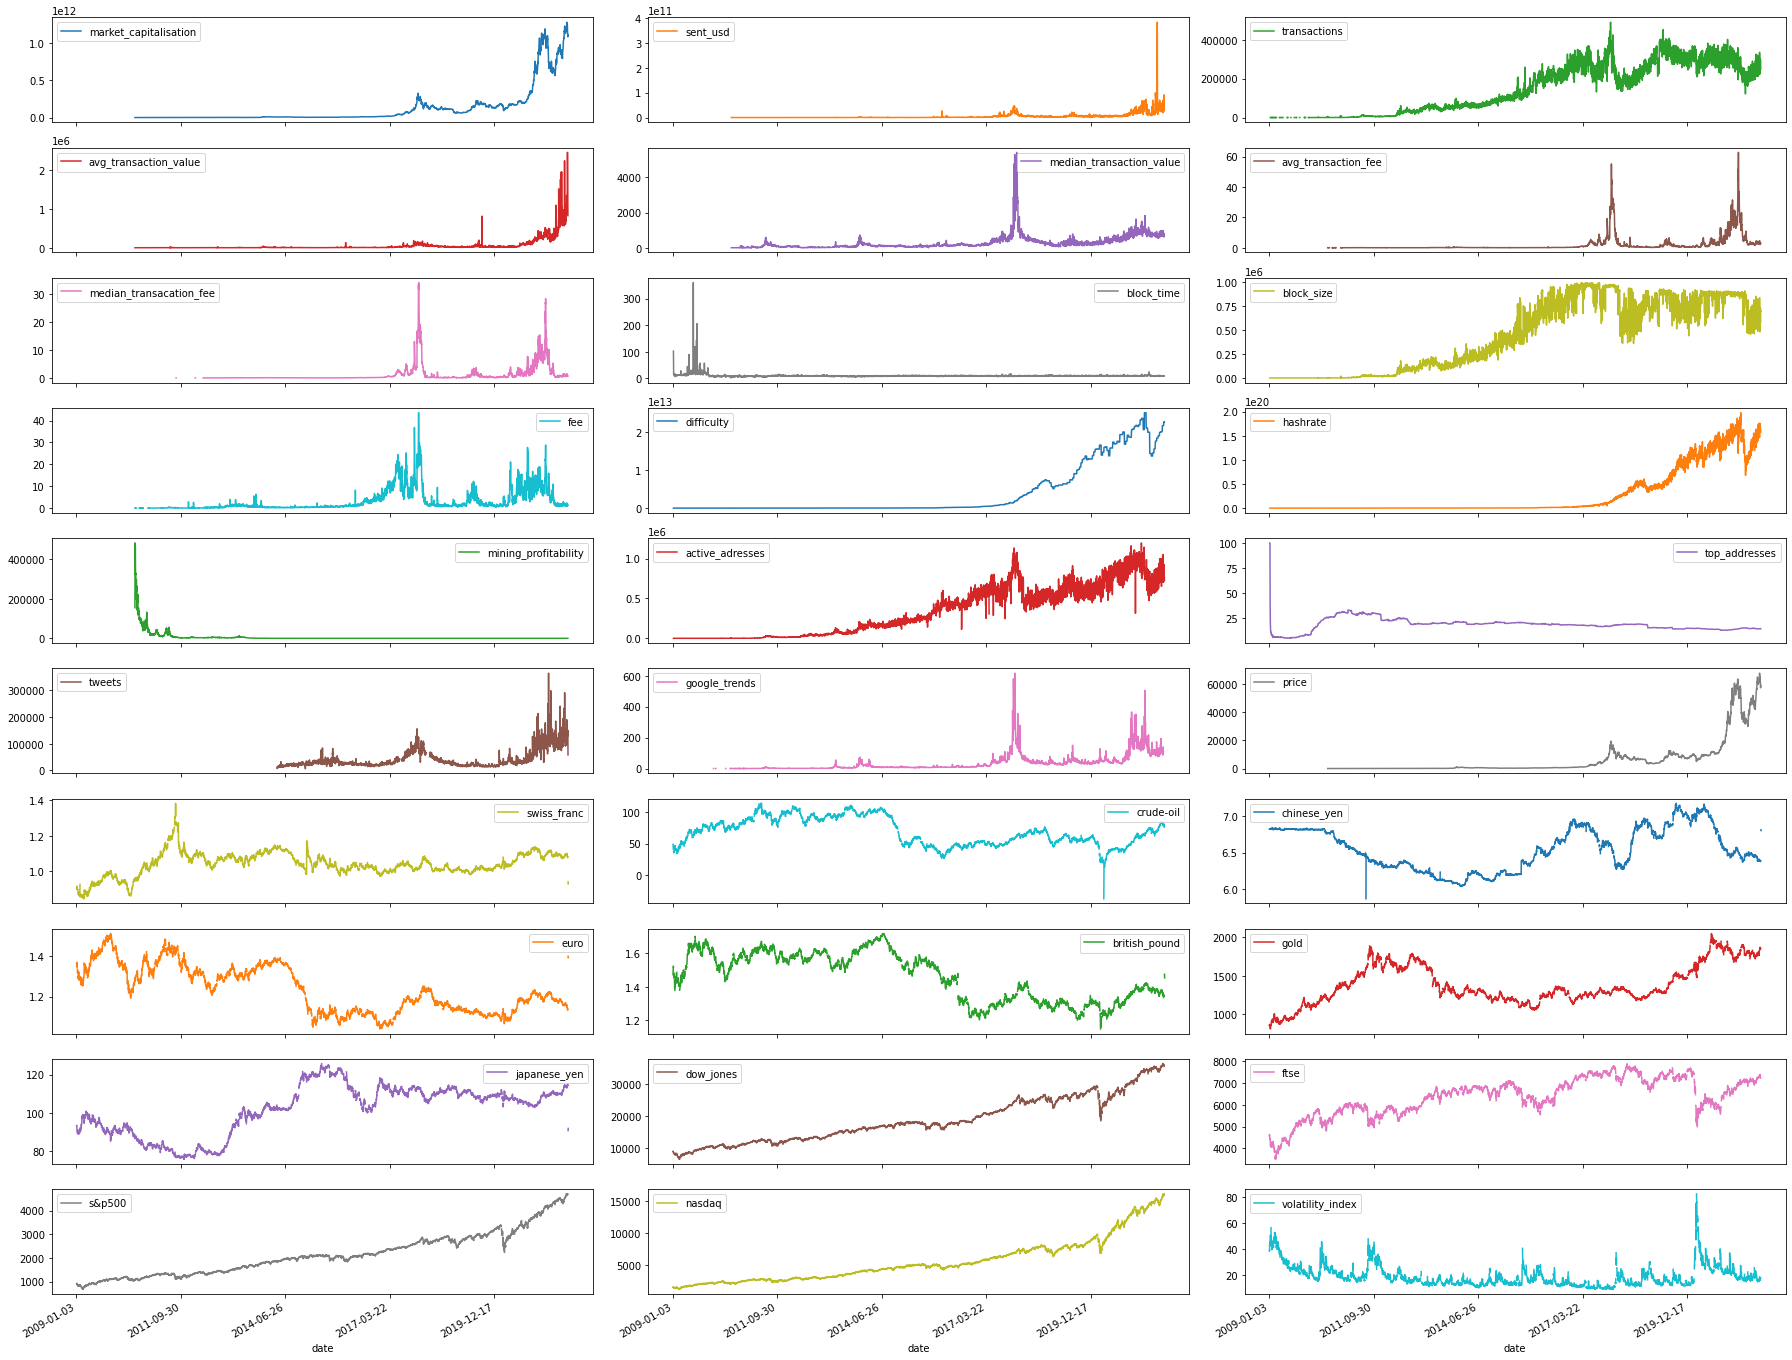

In [16]:
# visualising data
data.plot(x='date',subplots=True, layout = (10,3), figsize=(25,19))
plt.tight_layout()
plt.show()

On observing the graphs, we can see that in addition to the bitcoin's exchange price, the below listed variables have also seen an incremental growth in their trends:

* Blockchain Attributes: 
    * Market Capitalisation
    * Number of Transactions
    * Block Size
    * Mining Difficulty
    * Hash Rate
    * Number of Active Addresses
    
    
* Influential Stocks:
    * S&P500
    * NASDAQ
    * DOWJONES
    * FTSE

Constrastingly, mining difficulty has significantly gone down, presumably due to advancements in technology and upcoming blockchain frameworks that simplify the development process.

Some technological variables like transaction fee and block time have occasional peaks during the last decade but evetually come down to same value. Similarly there's no definitve trend with fiat currencies. They fluctuate rapidly and can not be associated with a conclusive gain or loss.

Lastly, tweets and google queries experience sudden rise and fall but have definitely risen over the years. Notably, we do not have any tweet records prior to 2014. Similarly a lot of technological attributes also have NaN values for the first 2 years. Thus we look at the missing values at a granular level in the next cell.

In [17]:
# empty entries in each column
data.isna().sum()

date                           2
market_capitalisation        563
sent_usd                     563
transactions                 263
avg_transaction_value        563
median_transaction_value     563
avg_transaction_fee          643
median_transacation_fee     1207
block_time                    10
block_size                     8
fee                          643
difficulty                     8
hashrate                       9
mining_profitability         563
active_adresses               30
top_addresses                 14
tweets                      1980
google_trends                571
price                        562
swiss_franc                 1354
crude-oil                   1488
chinese_yen                 1354
euro                        1351
british_pound               1351
gold                        1489
japanese_yen                1351
dow_jones                   1463
ftse                        1460
s&p500                      1463
nasdaq                      1463
volatility

## Data Preprocessing

Most of the blockchain attributes (including the dependent variable - bitcoin's exchange price) have empty records for exactly 563 days which loosely translates to 18 months worth of data. These can be classified as Missing Completely at Random or MCAR.

Likewise, economical features from Yahoo Finance also have a lot of emtpy records. On close inpection, we could decode that it's the weekend values that are missing ad that's understandable because the stock market works only on the weekdays.

While the former can not be imputed rationally, weekend values can easily be fixed using a forward fill. This way we are using the closing price on Friday as that on Saturday and Sunday as well.

In [18]:
# forward fill
for col in data.columns:
    data[col].fillna(method='ffill', inplace=True)

In [19]:
# convert string to date
data['date'] = pd.to_datetime(data['date'])

Coming back to the blockchain features, the bitcoin's exchange price did not change much until 2017. Although it increased from mere 0 in 2009 to a whopping 1000 in 2016 but its volatility post 2017 was exponentially high and way riskier in comparison. Thus we only the keep data 2015 onwards.

At the moment, each row has 30 features which represent the current day values. So we create a matrix type representation such that each row has input variables with not just current day's values but for the previous 2 days as well.

In [20]:
# day before yesterday
df_a = data[(data['date'] >= '2014-12-29')]
# yesterday's stats
df_b = data[(data['date'] >= '2014-12-30')]
# curent day stats
df_c = data[(data['date'] >= '2014-12-31')]
# OHE for day of the week
df_d = pd.get_dummies(df_c['date'].dt.day_name())
# next day's price
df_e = data[(data['date'] >= '2015-01-01')][['price']]

In [21]:
# rename columns
df_a.columns = ['2d_before_' + str(col) for col in df_a.columns]
df_b.columns = ['1d_before_' + str(col) for col in df_b.columns]
df_e.columns = ['next_day_' + str(col) for col in df_e.columns]

In [22]:
# list of dataframes
df_li = [df_a, df_b, df_c, df_d, df_e]

In [23]:
# preprocess each df
for df in df_li:
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
# merge all df(s) in df_li
df = pd.concat(df_li, axis=1)
df.head()

,2d_before_date,2d_before_market_capitalisation,2d_before_sent_usd,2d_before_transactions,2d_before_avg_transaction_value,2d_before_median_transaction_value,2d_before_avg_transaction_fee,2d_before_median_transacation_fee,2d_before_block_time,2d_before_block_size,2d_before_fee,2d_before_difficulty,2d_before_hashrate,2d_before_mining_profitability,2d_before_active_adresses,2d_before_top_addresses,2d_before_tweets,2d_before_google_trends,2d_before_price,2d_before_swiss_franc,2d_before_crude-oil,2d_before_chinese_yen,2d_before_euro,2d_before_british_pound,2d_before_gold,2d_before_japanese_yen,2d_before_dow_jones,2d_before_ftse,2d_before_s&p500,2d_before_nasdaq,2d_before_volatility_index,1d_before_date,1d_before_market_capitalisation,1d_before_sent_usd,1d_before_transactions,1d_before_avg_transaction_value,1d_before_median_transaction_value,1d_before_avg_transaction_fee,1d_before_median_transacation_fee,1d_before_block_time,1d_before_block_size,1d_before_fee,1d_before_difficulty,1d_before_hashrate,1d_before_mining_profitability,1d_before_active_adresses,1d_before_top_addresses,1d_before_tweets,1d_before_google_trends,1d_before_price,1d_before_swiss_franc,1d_before_crude-oil,1d_before_chinese_yen,1d_before_euro,1d_before_british_pound,1d_before_gold,1d_before_japanese_yen,1d_before_dow_jones,1d_before_ftse,1d_before_s&p500,1d_before_nasdaq,1d_before_volatility_index,date,market_capitalisation,sent_usd,transactions,avg_transaction_value,median_transaction_value,avg_transaction_fee,median_transacation_fee,block_time,block_size,fee,difficulty,hashrate,mining_profitability,active_adresses,top_addresses,tweets,google_trends,price,swiss_franc,crude-oil,chinese_yen,euro,british_pound,gold,japanese_yen,dow_jones,ftse,s&p500,nasdaq,volatility_index,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,next_day_price
0,2014-12-29,4.267536e+09,226685673.0,83283.0,3070.0,105.410,0.0546,0.0315,8.780,284084.0,0.352,3.945767e+10,3.318237e+17,3.904,168488.0,21.185,19605.0,6.933,314.822,1.011838,53.610001,6.2053,1.216945,1.555355,1181.699951,120.424004,18038.230469,6633.500000,2090.570068,4806.910156,15.060000,2014-12-30,4.236521e+09,275518820.0,84894.0,4042.0,139.882,0.0510,0.0312,9.290,301133.0,0.357,3.974013e+10,3.028547e+17,4.006,182178.0,21.227,19477.0,6.759,311.944,1.010611,54.119999,6.2125,1.215347,1.551590,1200.199951,120.632004,17983.070312,6547.000000,2080.350098,4777.439941,15.920000,2014-12-31,4.241986e+09,258858043.0,77259.0,3819.0,122.320,0.0461,0.0313,9.474,269665.0,0.299,4.064096e+10,3.218221e+17,3.704,158184.0,21.205,20017.0,6.933,312.724,1.011593,53.270000,6.1920,1.216205,1.556905,1183.900024,119.458000,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,315.626
1,2014-12-30,4.236521e+09,275518820.0,84894.0,4042.0,139.882,0.0510,0.0312,9.290,301133.0,0.357,3.974013e+10,3.028547e+17,4.006,182178.0,21.227,19477.0,6.759,311.944,1.010611,54.119999,6.2125,1.215347,1.551590,1200.199951,120.632004,17983.070312,6547.000000,2080.350098,4777.439941,15.920000,2014-12-31,4.241986e+09,258858043.0,77259.0,3819.0,122.320,0.0461,0.0313,9.474,269665.0,0.299,4.064096e+10,3.218221e+17,3.704,158184.0,21.205,20017.0,6.933,312.724,1.011593,53.270000,6.1920,1.216205,1.556905,1183.900024,119.458000,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,2015-01-01,4.287908e+09,129854868.0,59179.0,2500.0,78.474,0.0430,0.0316,8.727,187402.0,0.195,4.064096e+10,3.221646e+17,4.049,114998.0,21.241,18681.0,6.703,315.626,1.005925,53.270000,6.1961,1.209863,1.558094,1183.900024,119.672997,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,314.346
2,2014-12-31,4.241986e+09,258858043.0,77259.0,3819.0,122.320,0.0461,0.0313,9.474,269665.0,0.299,4.064096e+10,3.218221e+17,3.704,158184.0,21.205,20017.0,6.933,312.724,1.011593,53.270000,6.1920,1.216205,1.556905,1183.900024,119.458000,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,2015-01-01,4.287908e+09,129854868.0,59179.0,2500.0,78.474

In [25]:
# to confirm merge operation
df[['date', 'price', '1d_before_price', '2d_before_price']].head()

,date,price,1d_before_price,2d_before_price
0,2014-12-31,312.724,311.944,314.822
1,2015-01-01,315.626,312.724,311.944
2,2015-01-02,314.346,315.626,312.724
3,2015-01-03,303.591,314.346,315.626
4,2015-01-04,274.820,303.591,314.346


In [26]:
# use date as index
df.set_index('date', inplace=True)
# remove rows with NaN
df = df.iloc[1:-4]
# remove unnecesary columns
df.drop(['2d_before_date', '1d_before_date'], axis=1, inplace = True)
# create new columns
df['next_day_returns'] = df['next_day_price']-df['price']
df['next_day_log_returns'] = np.log(df['next_day_price']/df['price'])
# inspect df
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,2d_before_market_capitalisation,2d_before_sent_usd,2d_before_transactions,2d_before_avg_transaction_value,2d_before_median_transaction_value,2d_before_avg_transaction_fee,2d_before_median_transacation_fee,2d_before_block_time,2d_before_block_size,2d_before_fee,2d_before_difficulty,2d_before_hashrate,2d_before_mining_profitability,2d_before_active_adresses,2d_before_top_addresses,2d_before_tweets,2d_before_google_trends,2d_before_price,2d_before_swiss_franc,2d_before_crude-oil,2d_before_chinese_yen,2d_before_euro,2d_before_british_pound,2d_before_gold,2d_before_japanese_yen,2d_before_dow_jones,2d_before_ftse,2d_before_s&p500,2d_before_nasdaq,2d_before_volatility_index,1d_before_market_capitalisation,1d_before_sent_usd,1d_before_transactions,1d_before_avg_transaction_value,1d_before_median_transaction_value,1d_before_avg_transaction_fee,1d_before_median_transacation_fee,1d_before_block_time,1d_before_block_size,1d_before_fee,1d_before_difficulty,1d_before_hashrate,1d_before_mining_profitability,1d_before_active_adresses,1d_before_top_addresses,1d_before_tweets,1d_before_google_trends,1d_before_price,1d_before_swiss_franc,1d_before_crude-oil,1d_before_chinese_yen,1d_before_euro,1d_before_british_pound,1d_before_gold,1d_before_japanese_yen,1d_before_dow_jones,1d_before_ftse,1d_before_s&p500,1d_before_nasdaq,1d_before_volatility_index,market_capitalisation,sent_usd,transactions,avg_transaction_value,median_transaction_value,avg_transaction_fee,median_transacation_fee,block_time,block_size,fee,difficulty,hashrate,mining_profitability,active_adresses,top_addresses,tweets,google_trends,price,swiss_franc,crude-oil,chinese_yen,euro,british_pound,gold,japanese_yen,dow_jones,ftse,s&p500,nasdaq,volatility_index,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,next_day_price,next_day_returns,next_day_log_returns
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,4.236521e+09,275518820.0,84894.0,4042.0,139.882,0.0510,0.0312,9.290,301133.0,0.357,3.974013e+10,3.028547e+17,4.006,182178.0,21.227,19477.0,6.759,311.944,1.010611,54.119999,6.2125,1.215347,1.551590,1200.199951,120.632004,17983.070312,6547.000000,2080.350098,4777.439941,15.920000,4.241986e+09,258858043.0,77259.0,3819.0,122.320,0.0461,0.0313,9.474,269665.0,0.299,4.064096e+10,3.218221e+17,3.704,158184.0,21.205,20017.0,6.933,312.724,1.011593,53.270000,6.1920,1.216205,1.556905,1183.900024,119.458000,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,4.287908e+09,129854868.0,59179.0,2500.0,78.474,0.0430,0.0316,8.727,187402.0,0.195,4.064096e+10,3.221646e+17,4.049,114998.0,21.241,18681.0,6.703,315.626,1.005925,53.270000,6.1961,1.209863,1.558094,1183.900024,119.672997,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,314.346,-1.280,-0.004064
2015-01-02,4.241986e+09,258858043.0,77259.0,3819.0,122.320,0.0461,0.0313,9.474,269665.0,0.299,4.064096e+10,3.218221e+17,3.704,158184.0,21.205,20017.0,6.933,312.724,1.011593,53.270000,6.1920,1.216205,1.556905,1183.900024,119.458000,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,4.287908e+09,129854868.0,59179.0,2500.0,78.474,0.0430,0.0316,8.727,187402.0,0.195,4.064096e+10,3.221646e+17,4.049,114998.0,21.241,18681.0,6.703,315.626,1.005925,53.270000,6.1961,1.209863,1.558094,1183.900024,119.672997,17823.070312,6547.000000,2058.899902,4736.049805,19.200001,4.272409e+09,212156964.0,79122.0,2878.0,124.895,0.0470,0.0314,8.727,265055.0,0.286,4.064096e+10,3.302051e+17,3.938,184462.0,21.197,9385.0,7.625,314.346,1.005935,52.689999,6.1961,1.208941,1.557972,1186.000000,119.870003,17832.990234,6547.799805,2058.199951,4726.810059,17.790001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,303.591,-10.755,-0.034813
2015-01-03,4.287908e+09,129854868.0,59179.0,2500.0,78.474,0.0430,0.0316,8.727,187402.0,0.195,4.064096e+10,3.221646e+17,4.049,114998.0,21.241,18681.0,6.703,315.626,1.005925,53.270000,6.1961,1.209863,1.558094,1183.900024,119.672997,17823.070312,6547.000000,2

In [27]:
df.shape

(2517, 100)

In [28]:
# print column names
df.columns

Index(['2d_before_market_capitalisation', '2d_before_sent_usd',
       '2d_before_transactions', '2d_before_avg_transaction_value',
       '2d_before_median_transaction_value', '2d_before_avg_transaction_fee',
       '2d_before_median_transacation_fee', '2d_before_block_time',
       '2d_before_block_size', '2d_before_fee', '2d_before_difficulty',
       '2d_before_hashrate', '2d_before_mining_profitability',
       '2d_before_active_adresses', '2d_before_top_addresses',
       '2d_before_tweets', '2d_before_google_trends', '2d_before_price',
       '2d_before_swiss_franc', '2d_before_crude-oil', '2d_before_chinese_yen',
       '2d_before_euro', '2d_before_british_pound', '2d_before_gold',
       '2d_before_japanese_yen', '2d_before_dow_jones', '2d_before_ftse',
       '2d_before_s&p500', '2d_before_nasdaq', '2d_before_volatility_index',
       '1d_before_market_capitalisation', '1d_before_sent_usd',
       '1d_before_transactions', '1d_before_avg_transaction_value',
       '1d_before_

The final dataset comprises of 2400 records (from January 2015 to September 2021) and 100 columns. 

Each row contains values for all the features (30) for current day, the day before and the day before yesterday. We also included information about day of the week (7) using One Hot Encoding. Lastly, we include 3 dependent variables - tomorrow's raw price, raw returns and log-returns.

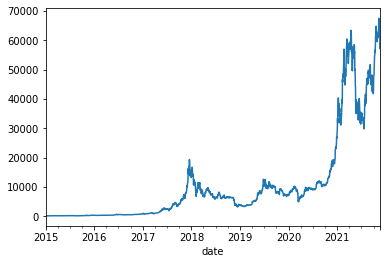

In [29]:
df['price'].plot()

## Data Modelling

Finally, as the data is ready to be fed into a ML model we use an ensembling technique called Random Forest (RF). Thus we intitalise a RF Regressor with 100 trees for One-Step-Ahead predictions. Although Boosting could have offered higher accuracy, we are more interested in optimal feature selection for which RF is the suitable choice.

In [30]:
# model
rf = RandomForestRegressor()

Here we create a function which takes 3 input values - dataset, algorithm and the boolean switch for normalisation (MinMax Scaler). It further splits the data into training and test set in the ratio 9:1 and fits the model to predict tomorrow's price. The predictions are plotted against true values on a graph and two error metrics are presented  - MAE and RMSE. 

In [31]:
# funtion to fit model and plot predictions
def predict_price(df, model, normalisation=True):
    
    ptr = round(len(df)*0.9)
    
    # split into train & test set
    train_X = df[:ptr].drop(['next_day_price', 'next_day_returns'], axis=1).values
    train_Y = df[:ptr]['next_day_price'].values
    
    test_X = df[ptr:].drop(['next_day_price', 'next_day_returns'], axis=1).values
    test_Y = df[ptr:]['next_day_price'].values
    
    if(normalisation==True):
        # normalisation
        train_Y = train_Y.reshape(-1,1)
        test_Y = test_Y.reshape(-1,1)
        scaler = MinMaxScaler()
        train_Y = scaler.fit_transform(train_Y).reshape(-1)
        test_Y = scaler.transform(test_Y).reshape(-1)
    
    # train model
    model.fit(train_X, train_Y)
    
    # predict
    predictions = model.predict(test_X)
    
    # test metrics
    print("\n")
    print('MAE: ', mean_absolute_error(test_Y, predictions))
    print('RMSE:',mean_squared_error(test_Y, predictions, squared=False))
    
    # visualisation
    plt.plot(predictions, label ='predicted')
    plt.plot(test_Y, label ='true value')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Predicting Bitcoin Price')
    plt.show()

Now we use the function to forecast prices on the entire dataset using a Random Forest Regressor no normalisation.



MAE:  23367.782125
RMSE: 26381.651961771437


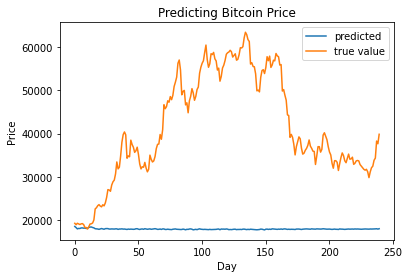

In [32]:
predict_price(df, rf, False)

As evident there's huge difference in the predictions and real values. This is due to the selection of training set rows. Our model trained on prices as high as 20,000 USD and nothing more than that. In specificity, the model trained on data from early 2015 to mid 2020 and was tested on mid 2020 onwards. However the bitcoin price skyrocketed late 2020 onwards and thus the discrepency in forecasting.

### Model 1
To fix this, we split the data into smaller sequential subsets and perform the predictions. I've set the number of days in each dataset as 600. You may alter this variable to experiment with other values. At the moment, we train on 540 days of data and then make one-step-ahead preditions for 60 days.

Test Set : 1 of 4


MAE:  37.23523850000006
RMSE: 39.293457323178835


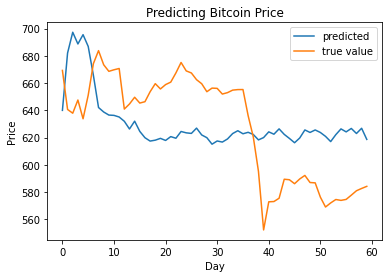

Test Set : 2 of 4


MAE:  386.7695000000001
RMSE: 469.0325977886115


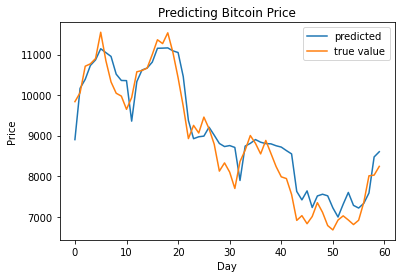

Test Set : 3 of 4


MAE:  180.51083333333335
RMSE: 271.7095450752513


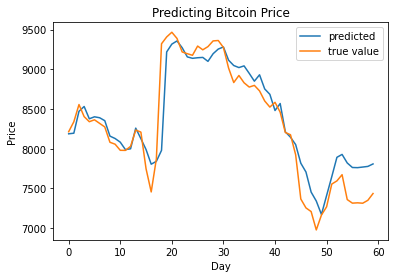

Test Set : 4 of 4


MAE:  1295.1049999999998
RMSE: 1601.9713618632513


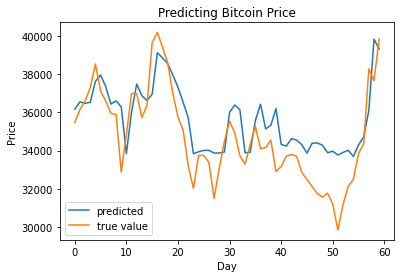

In [33]:
# number of days for each dataset
dataset_size = 600

# number of datasets
cases = round(len(df)/dataset_size)

# start day index
start = 0

# for each dataset
for case in range(cases):
    print("Test Set :", case+1, "of", cases)
    # last day index
    end = start + dataset_size
    # fit model and plot predictions
    predict_price(df[start:end], rf, False)
    # change start day index
    start+=dataset_size

While these results are better than the previous approach, it is still not reliable considering the magnitude of monetary risk involved. Nonetheless, the model is tracing the general trend with a lag and is a step in the right direction.

### Model 2

Right now, our model was directly predicting tomorrow's price. Instead, we will now make it predict the tomorrow's returns and add them to current day's price. This would better utilise the current day information instead of tuning the weights on this parameter (current day price).

Note, we have also included Naive Forecasts for comparison. In case these prices aren't predictable, it makes our series a random walk for which naive is probably the best approach.

In [34]:
# funtion to predict btc price using returns
def forecast_prices(df, model):
    ptr = round(len(df)*0.9)
    
    # split into train and test
    train_X = df[:ptr].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    train_Y = df[:ptr]['next_day_returns'].values

    test_X = df[ptr:].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    test_Y = df[ptr:]['next_day_returns'].values
    
    #train model
    model.fit(train_X, train_Y)

    # predict returns
    predicted_returns = model.predict(test_X)

    # compute price from returns
    predicted_price = [sum(x) for x in zip(df['price'][ptr:].values, predicted_returns)]
    # actual price
    true_price = df['next_day_price'][ptr:].values
    # naive forecasts
    naive_predictions = df['price'][ptr:].values
    
    # error metrics
    print("\n")
    print('Model MAE: ', mean_absolute_error(true_price, predicted_price))
    print('Naive MAE: ', mean_absolute_error(true_price, naive_predictions))
    print('Model RMSE:',mean_squared_error(true_price, predicted_price, squared=False))
    print('Naive RMSE:',mean_squared_error(true_price, naive_predictions, squared=False))

    # visualise results
    plt.plot(predicted_price, label ='predicted')
    plt.plot(true_price, label ='true value')
    plt.plot(naive_predictions, label = 'naive')
    plt.xlabel('Day')
    plt.ylabel("Price")
    plt.title('Predicting Bitcoin Price using Returns')
    plt.legend()
    plt.show()

In a hope to reduce the gap between actual and predicted values, we deploy our algorithm on the same four subsets of data.

Test Set : 1 of 4


Model MAE:  17.591272500000013
Naive MAE:  7.3395666666666655
Model RMSE: 20.664287129845114
Naive RMSE: 11.361866291826063


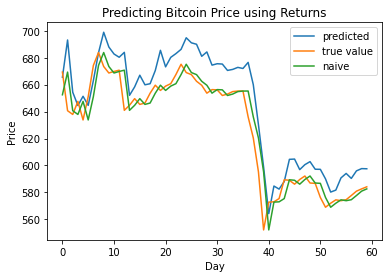

Test Set : 2 of 4


Model MAE:  337.4155410000001
Naive MAE:  328.73333333333335
Model RMSE: 412.94232448706543
Naive RMSE: 390.1454002462842


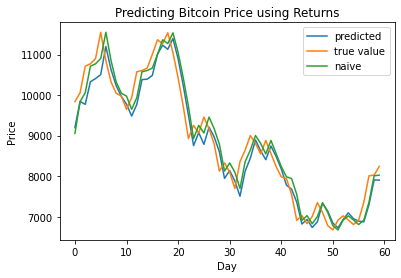

Test Set : 3 of 4


Model MAE:  178.23433333333338
Naive MAE:  143.93333333333334
Model RMSE: 273.0882235896183
Naive RMSE: 250.59874966434555


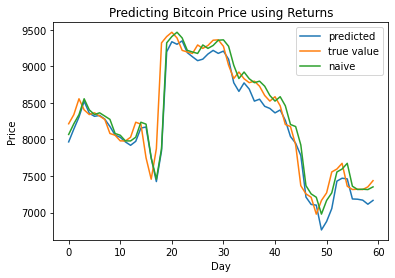

Test Set : 4 of 4


Model MAE:  1208.5503333333336
Naive MAE:  985.0
Model RMSE: 1548.7467231689845
Naive RMSE: 1271.2830395575436


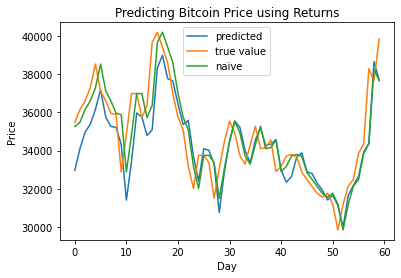

In [35]:
# number of days for each dataset
dataset_size = 600

# number of datasets
cases = round(len(df)/dataset_size)

# start day index
start = 0

# for each dataset
for case in range(cases):
    print("Test Set :", case+1, "of", cases)
    # last day index
    end = start + dataset_size
    # fit model and plot predictions
    forecast_prices(df[start:end], rf)
    # change start day index
    start+=dataset_size

### Model 3

There's considerable improvement in the performance but we are still far from beating the Naive errors. To do so, we further enhance our approach by predicting log-returns. 

In [36]:
# funtion to predict log returns
def forecast_log_returns(df, model):
    ptr = round(len(df)*0.9)
    
    # split into train and test
    train_X = df[:ptr].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    train_Y = df[:ptr]['next_day_log_returns'].values

    test_X = df[ptr:].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    test_Y = df[ptr:]['next_day_log_returns'].values
    
    # train model
    model.fit(train_X, train_Y)

    # predict log returns
    predicted_returns = model.predict(test_X)
    # actual log returns
    true_returns = test_Y
    # naive forecast for log returns
    naive_predictions = np.log(df['price']/df['1d_before_price'])[ptr:].values
    
    # error metrics
    print("\n")
    print('Model MAE: ', mean_absolute_error(true_returns, predicted_returns))
    print('Naive MAE: ', mean_absolute_error(true_returns, naive_predictions))
    print('Model RMSE:',mean_squared_error(true_returns, predicted_returns, squared=False))
    print('Naive RMSE:',mean_squared_error(true_returns, naive_predictions, squared=False))

    # visualisation
    plt.plot(predicted_returns, label ='predicted')
    plt.plot(true_returns, label ='true value')
    # plt.plot(naive_predictions, label = 'naive')
    plt.xlabel('Day')
    plt.ylabel("Returns")
    plt.title('Predicting Bitcoin Returns')
    plt.legend()
    plt.show()

We expect better results as log transformation approximates our series as stationary.

Test Set : 1 of 4


Model MAE:  0.02386150418435098
Naive MAE:  0.016462618252527837
Model RMSE: 0.029627735742402246
Naive RMSE: 0.02661446413826886


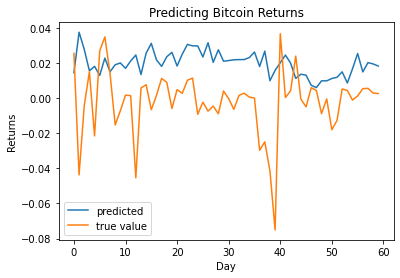

Test Set : 2 of 4


Model MAE:  0.03900769562781225
Naive MAE:  0.04243099538041882
Model RMSE: 0.04625733689827784
Naive RMSE: 0.05263941928645714


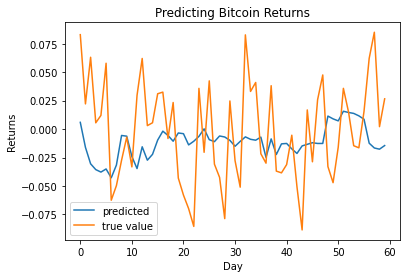

Test Set : 3 of 4


Model MAE:  0.020111862186876772
Naive MAE:  0.022505103923804063
Model RMSE: 0.03172962531481274
Naive RMSE: 0.03563844306310241


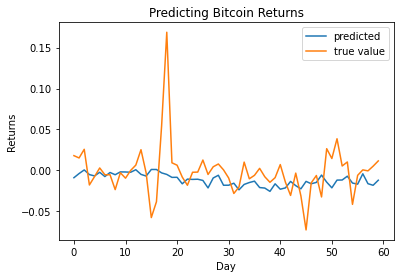

Test Set : 4 of 4


Model MAE:  0.03154457920262549
Naive MAE:  0.03573614246140195
Model RMSE: 0.040717996185095535
Naive RMSE: 0.0486343842534521


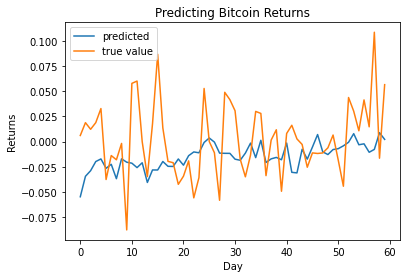

In [37]:
# number of days for each dataset
dataset_size = 600

# number of datasets
cases = round(len(df)/dataset_size)

# start day index
start = 0

# for each dataset
for case in range(cases):
    print("Test Set :", case+1, "of", cases)
    # last day index
    end = start + dataset_size
    # fit model and plot predictions
    forecast_log_returns(df[start:end], rf)
    # change start day index
    start+=dataset_size

The model performs close enough to the constant zero. Thus we predict log-returns and then transform those into raw values using an exponential. And then follow the previous approach of adding the returns to current day price.

In [38]:
# funtion to predict price from log returns
def forecast_price_from_returns(df, model):
    ptr = round(len(df)*0.9)
    
    train_X = df[:ptr].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    train_Y = df[:ptr]['next_day_log_returns'].values

    test_X = df[ptr:].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    test_Y = df[ptr:]['next_day_log_returns'].values
    
    # model.set_params(n_estimators=1000)
    
    model.fit(train_X, train_Y)
    predicted_returns = model.predict(test_X)
    
    raw_returns = np.exp(predicted_returns)
    predicted_price = [sum(x) for x in zip(df['price'][ptr:].values, raw_returns)]
    
    true_price = df['next_day_price'][ptr:].values
    naive_predictions = df['price'][ptr:].values
    
    print("\n")
    print('Model MAE: ', mean_absolute_error(true_price, predicted_price))
    print('Naive MAE: ', mean_absolute_error(true_price, naive_predictions))
    print('Model RMSE:',mean_squared_error(true_price, predicted_price, squared=False))
    print('Naive RMSE:',mean_squared_error(true_price, naive_predictions, squared=False))
    
    plt.plot(predicted_price, label ='predicted')
    plt.plot(true_price, label ='true value')
    plt.plot(naive_predictions, label = 'naive')
    plt.xlabel('Day')
    plt.ylabel("Price")
    plt.title('Predicting Bitcoin Price using Returns')
    plt.legend()
    plt.show()

Test Set : 1 of 4


Model MAE:  7.299420973034066
Naive MAE:  7.3395666666666655
Model RMSE: 11.50994686617635
Naive RMSE: 11.361866291826063


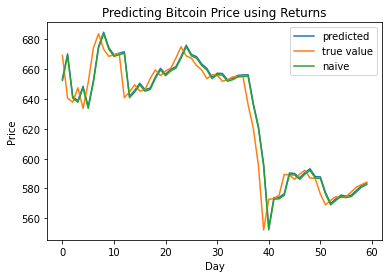

Test Set : 2 of 4


Model MAE:  328.7343149757995
Naive MAE:  328.73333333333335
Model RMSE: 390.1799504381827
Naive RMSE: 390.1454002462842


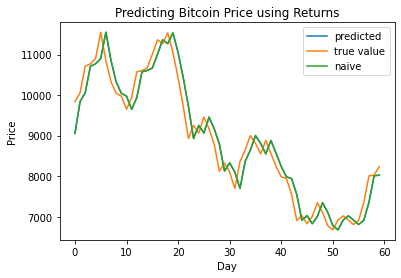

Test Set : 3 of 4


Model MAE:  144.0981872950378
Naive MAE:  143.93333333333334
Model RMSE: 250.64190049205723
Naive RMSE: 250.59874966434555


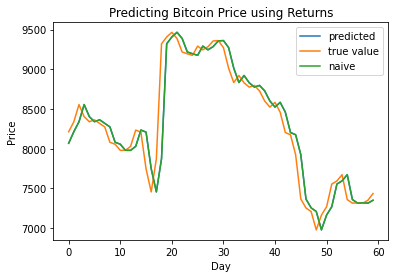

Test Set : 4 of 4


Model MAE:  985.0010115485152
Naive MAE:  985.0
Model RMSE: 1271.2242247971503
Naive RMSE: 1271.2830395575436


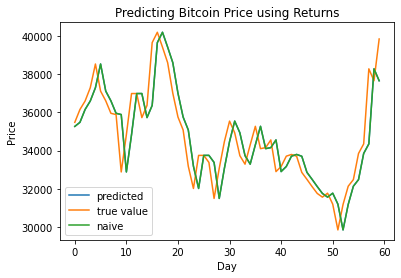

In [39]:
# number of days for each dataset
dataset_size = 600

# number of datasets
cases = round(len(df)/dataset_size)

# start day index
start = 0

# for each dataset
for case in range(cases):
    print("Test Set :", case+1, "of", cases)
    # last day index
    end = start + dataset_size
    # fit model and plot predictions
    forecast_price_from_returns(df[start:end], rf)
    # change start day index
    start+=dataset_size

The model predictions (in blue) are so closely aligned to naive forecasts (green) that we cannot tell the difference visually. This is defnitely better than the earlier observed variance but can not be used as a metric due to high noise in our data. All the datasets have same RMSE for our model as that of the naive forecast, suggesting that the model does perform quite well.

## Feature Importance

This implies that the model must be producing genuine forecasts. So we check the feature importance for each test set, which was the underlying purpose of this research. That is, we now have a look at the most influential input-variables in each time-period.

In [40]:
def get_features(df, model):
    ptr = round(len(df)*0.9)
    
    train_X = df[:ptr].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    train_Y = df[:ptr]['next_day_log_returns'].values

    test_X = df[ptr:].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    test_Y = df[ptr:]['next_day_log_returns'].values
    
    model.set_params(n_estimators=100)
    model.fit(train_X, train_Y)
    feat_importances = pd.Series(model.feature_importances_, index=df.drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.tight_layout()
    plt.show()
    

Test Set : 1 of 4


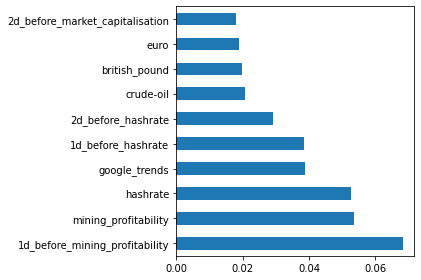

Test Set : 2 of 4


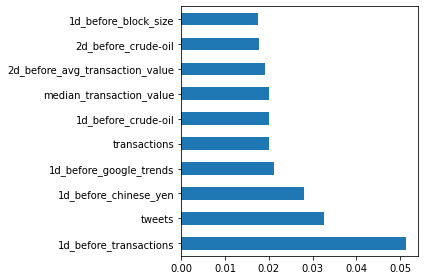

Test Set : 3 of 4


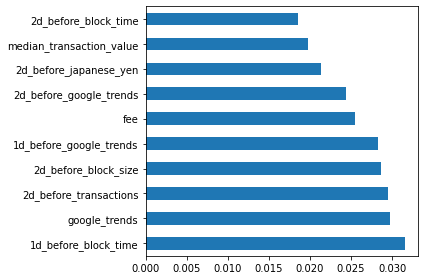

Test Set : 4 of 4


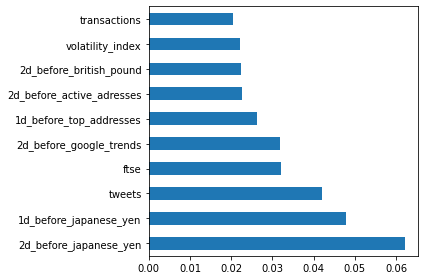

In [41]:
# number of days for each dataset
dataset_size = 600

# number of datasets
cases = round(len(df)/dataset_size)

# start day index
start = 0

# for each dataset
for case in range(cases):
    print("Test Set :", case+1, "of", cases)
    # last day index
    end = start + dataset_size
    # fit model and plot predictions
    get_features(df[start:end], rf)
    # change start day index
    start+=dataset_size

We observe that in early times (from 2015 to mid 2016) hash-rate, mining profitability, market capitalisation, block time, Euro and google trends were the top 10 estimators, in the order of their importance. It is clearly evident that blockchain attributes had a great influence on Bitcoin’s exchange price and macroeconomic features had no role whatsoever. This is probably because Bitcoin did not get as hyped up as it did after 2017 (on hitting $20,000).

Moving on to the next time period, from late 2016 to early 2018 — tweets, google trends, Chinese Yen, crude oil, transaction count, transaction value and block size seem to be quite influential. As per our expectation, the economic involvement is slightly increasing. Moreover, tweets have also shown some influence by this time.

From mid 2018 to late 2019 — google trends, transaction count, block time, bock size, Japanese Yen, transaction fee, active addresses and transaction value have shown to be quite important in determining the bitcoin price. Surprisingly, there is negligible involvement of macroeconomic features while technological attributes continue to have control over the price. Google seems to be present across all the years up till now.

Finally, we look at the recent months (early 2020 onwards) when the world economy was hit by global pandemic — Japanese Yen, British pound, FTSE, volatility index, top addresses, transaction count, google trends, tweets, constitute the important feature set. Contrastingly, the blockchain involvement has significantly dropped and the economic features have suddenly taken a strong control over bitcoin pricing. Yet again google and tweets are still relevant.

## Statistical Testing

We use a Diebold Mariano test to compare the forecast accuracies of our model against the naive to ensure the results are statistically significant.

$H_{0}$ : the two forecasts have same level of accuracy

$H_{1}$ : the two forecasts have different level of accuracy

The funtion beneath returns 3 variables - true price, naive forecasts and model forecasts which would later be fed into the function from dm_test library.

In [42]:
from dm_test import dm_test

In [43]:
def get_prices(df, model):
    ptr = round(len(df)*0.9)
    
    train_X = df[:ptr].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    train_Y = df[:ptr]['next_day_log_returns'].values

    test_X = df[ptr:].drop(['next_day_price','next_day_returns','next_day_log_returns'], axis=1).values
    test_Y = df[ptr:]['next_day_log_returns'].values
    
    model.set_params(n_estimators=1000)
    model.fit(train_X, train_Y)
    predicted_returns = model.predict(test_X)
    
    raw_returns = np.exp(predicted_returns)
    predicted_price = [sum(x) for x in zip(df['price'][ptr:].values, raw_returns)]
    
    true_price = df['next_day_price'][ptr:].values
    naive_predictions = df['price'][ptr:].values
    
    return true_price, naive_predictions, predicted_price

In [44]:
# number of days for each dataset
dataset_size = 600

# number of datasets
cases = round(len(df)/dataset_size)

# start day index
start = 0

# for each dataset
for case in range(cases):
    print("Test Set :", case+1, "of", cases)
    # last day index
    end = start + dataset_size
    # fit model and plot predictions
    output_li = get_prices(df[start:end], rf)
    rt = dm_test(output_li[0],output_li[1],output_li[2],h = 1, crit="MSE")
    print(rt)
    print("\n")
    # change start day index
    start+=dataset_size

Test Set : 1 of 4
dm_return(DM=-1.1267448677582803, p_value=0.26441228911789466)


Test Set : 2 of 4
dm_return(DM=-0.27473070071254185, p_value=0.7844828817336525)


Test Set : 3 of 4
dm_return(DM=-0.3351585192332609, p_value=0.7386942756220234)


Test Set : 4 of 4
dm_return(DM=0.46463968850811144, p_value=0.6438996678665686)




With high p-values we could not reject the null hypothesis.

## Conclusions

* The potential influence on bitcoin price transitioned from technological features (early years) towards the economic ones (current day).

* The random forest and naïve forecast have different forecast-accuracies and the results were insignificantly less accurate.

* It is a non-stationary time series with stochastic trends and thus could not be predicted.

* The dynamics for Bitcoin change drastically and determining their returns is not plausible